In [39]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
import bct
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import wilcoxon, ttest_rel, sem
import seaborn as sns
from statsmodels import robust

In [41]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
rcParams['figure.autolayout'] = True
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches

In [42]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

In [43]:
outfolder = '/imaging/jb07/ZDHHC9/connectome_revisions/figures/'

In [44]:
def plot_adjacency_matrix(network):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=(double_column/3, double_column/3), dpi=300)
    im = plt.imshow(network, 
               cmap='jet',
               interpolation='none',
               vmin=0)
    ax = plt.gca()
    ax.grid('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)

In [45]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix0/' + subject + '_dwi_' + model + '_' + threshold + '_matrix' + weight + '.txt'
    matrix = np.loadtxt(matrix)
    
    return matrix

In [46]:
folder = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/'

In [47]:
subject_list = sorted([subject.split('_')[-1] for subject in os.listdir(folder) if re.search('subject', subject)])

## Plotting different matrix weights

In [48]:
networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(0), '', subject) for subject in subject_list]), 0, 3)
networks = np.asarray([bct.binarize(bct.threshold_proportional(network, 0.1)) for network in networks])
control_network = np.mean(networks[..., 0:7], axis=2)
ZDHHC9_network = np.mean(networks[..., 7:], axis=2)

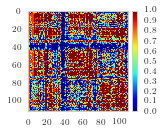

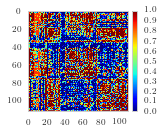

In [49]:
plot_adjacency_matrix(control_network)
plot_adjacency_matrix(ZDHHC9_network)

# Group differences using different defintions of edge weight

In [50]:
def calculate_results(subject_list, threshold_range, model, weight, threshold_type, annotation, figure_name):
    
    d = []

    for subject in subject_list:
        for threshold in threshold_range:

            # Loading the data
            network = load_data(folder, model, str(0), weight, subject)

            # thresholding
            if threshold_type == 'proportional':
                network = bct.threshold_proportional(network, threshold)
            elif threshold_type == 'absolute':
                network = bct.threshold_absolute(network, threshold)

            # binarizing
            network = bct.binarize(network)

            # calculate average clustering
            clustering_coefficient = np.mean(bct.clustering_coef_bu(network))
            global_efficiency = bct.charpath(bct.distance_bin(network))[1]

            # Setting group variable
            group = 'ZDHHC9' if re.search('z', subject) else 'control'

            d.append({'ID': subject,
                      'group': group,
                      'threshold': threshold,
                      'clustering_coefficient': clustering_coefficient,
                      'global_efficiency': global_efficiency})

    df = pd.DataFrame(d)
    
    for measure in ['clustering_coefficient', 'global_efficiency']:
        control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
        ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
        print measure + '\n'
        print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
             '; SE=' + str(round(sem(ZDHHC9_area), 3)))
        print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
             '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
        print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
             '; SE=' + str(round(sem(control_area), 3)))
        print('control AUC: median=' + str(round(np.median(control_area), 2)) +
             '; mad=' + str(round(robust.mad(control_area), 3)))
        print('Wilcoxon: W=' + 
        str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
        str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
        print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
        str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
        str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')
        
    # Plotting
    fig = plt.figure(figsize=(double_column/3, double_column/3), dpi=600)

    for measure in ['clustering_coefficient', 'global_efficiency']:
        for group in ['control', 'ZDHHC9']:

            copy_df = df.copy()
            copy_df = copy_df[df['group'] == group]
            median = copy_df.groupby('threshold').median()[measure].values
            mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
            colour = '#56B4E9' if group == 'control' else '#D55E00'
            marker = 'o' if measure == 'clustering_coefficient' else 'D'
            linestyle = 'solid' if measure == 'clustering_coefficient' else 'dashed'

            plt.errorbar(x = threshold_range,
                         y = median,
                         yerr = mad,
                         marker = marker,
                         markersize = 2,
                         color=colour,
                         linestyle=linestyle,
                         linewidth=1)


    plt.ylim(ymax = 1, ymin = 0)
    #plt.tight_layout(w_pad=4., h_pad=4.)
    
    if annotation:
        plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
        plt.ylabel(r'$C_{G}$/$L_{G}^-1$')
        plt.xlabel(r'thresholded density')
        
    plt.savefig(figure_name, dpi=300)
    plt.show()


## 1. Streamline density

### 1.1 Streamline density with proportional thresholding

Streamline densities are absolute counts. These need to be thresholded to create binary graphs so that the graph metrics can be calculated. The binarization threshold may significantly influence the results. Therefore, a range of thresholds is tested. Further, thresholding may be proportional or to an absolute value. The proportional value conserves the overall density of the graph, but may level differences between cases and controls. In order to establish how robust differences are, both strategies are implemented and compared. 

clustering_coefficient

ZDHHC9 AUC: mean=11.41; SE=0.051
ZDHHC9 AUC: median=11.37; mad=0.152
control AUC: mean=11.81; SE=0.03
control AUC: median=11.82; mad=0.072
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=7.35; p=0.0

global_efficiency

ZDHHC9 AUC: mean=11.27; SE=0.052
ZDHHC9 AUC: median=11.26; mad=0.102
control AUC: mean=11.64; SE=0.03
control AUC: median=11.65; mad=0.092
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.25; p=0.0



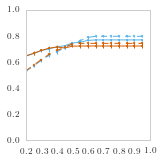

In [51]:
threshold_range = np.arange(0.2, 1., 0.05)
calculate_results(subject_list, threshold_range, 'CSD', '', 'proportional', False, outfolder + 'streamline_density_proportional.png')

The graph shows the group median of the average clustering coefficient at each density threshold for the *ZDHHC9* group (orange) and the control group (blue). The error bars show the bootstrapped 95% confidence interval.

### 1.2. Streamline density differences with absolute thresholding

clustering_coefficient

ZDHHC9 AUC: mean=2.85; SE=0.12
ZDHHC9 AUC: median=2.83; mad=0.257
control AUC: mean=3.4; SE=0.13
control AUC: median=3.48; mad=0.178
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=3.07; p=0.022

global_efficiency

ZDHHC9 AUC: mean=1.78; SE=0.072
ZDHHC9 AUC: median=1.73; mad=0.124
control AUC: mean=2.07; SE=0.066
control AUC: median=2.08; mad=0.184
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=4.11; p=0.006



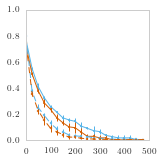

In [52]:
threshold_range = np.arange(0, 500, 25)
df = calculate_results(subject_list, threshold_range, 'CSD', '', 'absolute', False, outfolder + 'streamline_density_absolute.png')

## 2. Streamline density normalized by ROI size

clustering_coefficient

ZDHHC9 AUC: mean=11.3; SE=0.037
ZDHHC9 AUC: median=11.31; mad=0.144
control AUC: mean=11.61; SE=0.031
control AUC: median=11.58; mad=0.044
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.89; p=0.001

global_efficiency

ZDHHC9 AUC: mean=11.36; SE=0.05
ZDHHC9 AUC: median=11.36; mad=0.143
control AUC: mean=11.78; SE=0.03
control AUC: median=11.79; mad=0.068
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.41; p=0.0



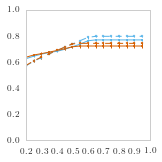

In [53]:
threshold_range = np.arange(0.2, 1., 0.05)
df = calculate_results(subject_list, threshold_range, 'CSD', '_ROI_normalized', 'proportional', False, outfolder + 'ROI_normalized.png')

## 3. Streamline density normalized by streamline length

clustering_coefficient

ZDHHC9 AUC: mean=9.47; SE=0.086
ZDHHC9 AUC: median=9.41; mad=0.219
control AUC: mean=10.27; SE=0.102
control AUC: median=10.25; mad=0.29
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=9.14; p=0.0

global_efficiency

ZDHHC9 AUC: mean=11.52; SE=0.039
ZDHHC9 AUC: median=11.54; mad=0.122
control AUC: mean=11.91; SE=0.037
control AUC: median=11.93; mad=0.14
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=16.04; p=0.0



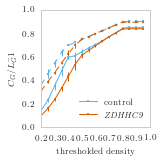

In [54]:
threshold_range = np.arange(0.2, 1., 0.05)
df = calculate_results(subject_list, threshold_range, 'CSD', '_length_normalized', 'proportional', True, outfolder + 'length_normalized.png')

## 2. Influence of crossing fibres

In [55]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    if weight == '_FA':
        weight_switch = str(0)
    elif weight == '_RD':
        weight_switch = str(1)
    elif weight == '_GFA':
        weight_switch = str(2)
        
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix' + weight_switch + '/' + subject + weight + '_matrix.txt'
    matrix = np.loadtxt(matrix)
    
    return matrix

In [56]:
def calculate_results(subject_list, threshold_range, model, weight, annotation, figure_name):
    d = []
    threshold_range = np.arange(0,100,10)

    for subject in subject_list:
        for threshold in threshold_range:

            # Loading the data
            network = load_data(folder, model, str(threshold), '_FA', subject)
            network[np.isnan(network)] = 0 # removing NaN

            # Calculating graph metrics
            clustering_coefficient = np.mean(bct.clustering_coef_wu(network))
            global_efficiency = bct.charpath(bct.distance_wei(bct.weight_conversion(network, 'lengths'))[0])[1]

            # Setting group variable
            group = 'ZDHHC9' if re.search('z', subject) else 'control'

            # Collecting the data
            d.append({'ID':subject, 
                      'threshold': threshold,
                      'group': group,
                      'clustering_coefficient': clustering_coefficient,
                      'global_efficiency': global_efficiency})

    df = pd.DataFrame(d)

    for measure in ['clustering_coefficient', 'global_efficiency']:
        control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
        ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
        print measure + '\n'
        print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
             '; SE=' + str(round(sem(ZDHHC9_area), 3)))
        print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
             '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
        print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
             '; SE=' + str(round(sem(control_area), 3)))
        print('control AUC: median=' + str(round(np.median(control_area), 2)) +
             '; mad=' + str(round(robust.mad(control_area), 3)))
        print('Wilcoxon: W=' + 
        str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
        str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
        print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
        str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
        str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')
        

    # Plotting
    fig = plt.figure(figsize=(double_column/3, double_column/3), dpi=600)

    for measure in ['clustering_coefficient', 'global_efficiency']:
        for group in ['control', 'ZDHHC9']:

            copy_df = df.copy()
            copy_df = copy_df[df['group'] == group]
            median = copy_df.groupby('threshold').median()[measure].values
            mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
            colour = '#56B4E9' if group == 'control' else '#D55E00'
            marker = 'o' if measure == 'clustering_coefficient' else 'D'
            linestyle = 'solid' if measure == 'clustering_coefficient' else 'dashed'

            plt.errorbar(x = threshold_range,
                         y = median,
                         yerr = mad,
                         marker = marker,
                         markersize = 2,
                         color=colour,
                         linestyle=linestyle,
                         linewidth=1)


    plt.ylim(ymax = 0.5, ymin = 0)

    if annotation:
        plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')

    plt.savefig(figure_name, dpi=300)
    plt.show()

clustering_coefficient

ZDHHC9 AUC: mean=0.81; SE=0.044
ZDHHC9 AUC: median=0.81; mad=0.098
control AUC: mean=1.13; SE=0.041
control AUC: median=1.13; mad=0.137
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=10.81; p=0.0

global_efficiency

ZDHHC9 AUC: mean=0.52; SE=0.023
ZDHHC9 AUC: median=0.52; mad=0.03
control AUC: mean=0.8; SE=0.028
control AUC: median=0.8; mad=0.094
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.47; p=0.0



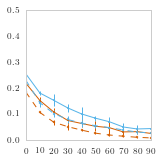

In [57]:
threshold_range = np.arange(0,100,10)
calculate_results(subject_list, threshold_range, 'CSD', '_FA', False, outfolder + 'FA_weighted.png')

clustering_coefficient

ZDHHC9 AUC: mean=0.81; SE=0.044
ZDHHC9 AUC: median=0.81; mad=0.098
control AUC: mean=1.13; SE=0.041
control AUC: median=1.13; mad=0.137
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=10.81; p=0.0

global_efficiency

ZDHHC9 AUC: mean=0.52; SE=0.023
ZDHHC9 AUC: median=0.52; mad=0.03
control AUC: mean=0.8; SE=0.028
control AUC: median=0.8; mad=0.094
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.47; p=0.0



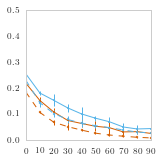

In [58]:
threshold_range = np.arange(0,100,10)
calculate_results(subject_list, threshold_range, 'CSD', '_GFA', False, outfolder + 'GFA_weighted.png')

## 3. Influence of diffusion type

clustering_coefficient

ZDHHC9 AUC: mean=1.0; SE=0.034
ZDHHC9 AUC: median=0.99; mad=0.089
control AUC: mean=1.3; SE=0.085
control AUC: median=1.27; mad=0.337
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=3.64; p=0.011

global_efficiency

ZDHHC9 AUC: mean=0.7; SE=0.032
ZDHHC9 AUC: median=0.75; mad=0.048
control AUC: mean=1.02; SE=0.051
control AUC: median=1.05; mad=0.133
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=9.83; p=0.0



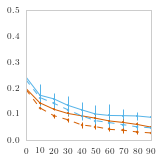

In [59]:
threshold_range = np.arange(0,100,10)
calculate_results(subject_list, threshold_range, 'CSA', '_FA', False, outfolder + 'CSA_FA_weighted.png')